In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Reading data

In [14]:

def read_data(data_path):
    """
    Reads and processes data from specified path in data_path. 
    Data is balanced with SMOTE, and split into test, labelled train, and unlabelled train sets.

    Return: unlabelled and labelled sets, test set, where x_jjjj are data and y_jjjj are labels.
    """
    df = pd.read_csv(data_path)
    df = df.drop(columns=["Amount", "Time"])
    labels = df["Class"]
    data = df.drop(columns=["Class"])

    ratio = min(labels.value_counts())/(max(labels.value_counts())/2)
    # Undersamples half of majority class 
    rnd_under_sam = RandomUnderSampler(sampling_strategy=ratio, random_state=42)
    data_res, labels_res = rnd_under_sam.fit_resample(data, labels)
    # Oversamples data
    sm = SMOTE(sampling_strategy='minority',random_state=42)
    data_res, labels_res = sm.fit_resample(data_res, labels_res)
    return data_res, labels_res

In [15]:
data_path = './creditcard.csv'
# Reading and balancing data
data, labels = read_data(data_path)

### Splitting data

In [16]:
def split_data(data, labels):
    """
    Splits data into test, and labelled and unlaballed train sets.
    """
    # Split into train and test
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                        stratify=labels)
    # Split train into unlabelled and labelled train sets
    x_train_unlab, x_train_lab, y_train_unlab, y_train_lab = \
        train_test_split(x_train, y_train, test_size=0.3, stratify=y_train)
    y_train_unlab = pd.Series(-1, index=y_train_unlab.index, name='Class')

    return x_train_unlab, y_train_unlab, x_train_lab, y_train_lab, x_test, y_test

### Models

In [17]:
class Model:
      def __init__(self, model, name):
        self.model = model
        self.name = name

def run_model(model, train_data, train_labels, test_data, test_labels):
    """
    Runs a model and returns accuracy and f1
    """
    model.fit(train_data, train_labels)
    yhat = model.predict(test_data)
    yhat = [int(i) for i in yhat]
    accuracy = accuracy_score(test_labels, yhat)
    f_1 = f1_score(test_labels, yhat)
    return [accuracy, f_1], model

In [ ]:
# Selects the baseline classification and SSL models
baseline = Model(RandomForestClassifier(), "Random Forest")
ssl = Model(LabelPropagation(kernel='knn', n_jobs=-1), "KNN Label Propagation")
accuracy_baseline = []
f1_baseline = []
accuracy_ssl = []
f1_ssl = []
accuracy_baseline_ssl = []
f1_baseline_ssl = []
n_iter = 100

for iter in range(n_iter):
    x_train_unlab, y_train_unlab, x_train_lab, y_train_lab, x_test, y_test = split_data(data, labels)

    # Runs classification model on lab train data and tests it
    print(iter, "Running baseline model on labeled data...")
    results, _ = run_model(baseline.model, x_train_lab, y_train_lab, x_test, y_test)
    accuracy_baseline.append(results[0])
    f1_baseline.append(results[1])

    # Runs SSL model on all training data and tests it
    x_train = pd.concat([x_train_lab, x_train_unlab], axis=0)
    y_ssl = pd.concat([y_train_lab, y_train_unlab], axis=0)
    #print("Running SSL model...")
    results, ssl_model = run_model(ssl.model, x_train, y_ssl, x_test, y_test)
    accuracy_ssl.append(results[0])
    f1_ssl.append(results[1])

    # Runs baseline model on all training data using the labels obtained from SSL and tests it
    y_train_ssl = ssl_model.transduction_
    #print("Running baseline model with SSL labels on all data...")
    results, _ = run_model(baseline.model, x_train, y_train_ssl, x_test, y_test)
    accuracy_baseline_ssl.append(results[0])
    f1_baseline_ssl.append(results[1])

### Results

In [19]:
def plot_results(accuracy, title, color):
    plt.axhline(y = np.mean(accuracy), xmin = 0, xmax = 100, color=color, linestyle="dashed")
    plt.plot(np.arange(0, len(accuracy)), accuracy, label=title, color=color)
    plt.xlabel('Run')
    plt.ylim(0.995, 1)
    plt.xticks(np.arange(0, 110, 10))

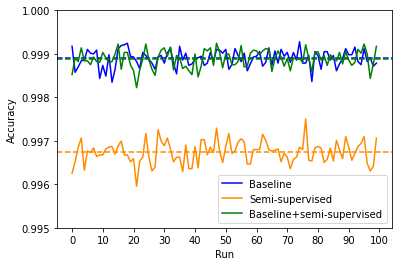

Baseline:
Mean accuracy: 0.9988934808223274 
Mean f1: 0.9988932652684239
SLL:
Mean accuracy: 0.9967390042734291 
Mean f1: 0.9967463245256267
Baseline SLL:
Mean accuracy: 0.9988820498390869 
Mean f1: 0.9988820034373654


In [22]:
plot_results(accuracy_baseline, 'Baseline', "blue")
plot_results(accuracy_ssl, 'Semi-supervised', "darkorange")
plot_results(accuracy_baseline_ssl, 'Baseline+semi-supervised', "green")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("task2_plot.pdf", bbox_inches='tight')
plt.show()
print("Baseline:\nMean accuracy: {} \nMean f1: {}".format(np.mean(accuracy_baseline), np.mean(f1_baseline)))
print("SLL:\nMean accuracy: {} \nMean f1: {}".format(np.mean(accuracy_ssl), np.mean(f1_ssl)))
print("Baseline SLL:\nMean accuracy: {} \nMean f1: {}".format(np.mean(accuracy_baseline_ssl), np.mean(f1_baseline_ssl)))